# Aula Prática - Processamento de Imagem com Python
Este notebook está preparado para rodar **no Google Colab**. Ele baixa os arquivos do repositório, entra na pasta correta e carrega a imagem de exemplo.

In [20]:
# 🔁 Resetar, clonar e garantir a imagem no caminho correto
import os, shutil, pathlib, subprocess, sys

REPO = "aula-pratica-python"
URL  = "https://github.com/duchio/aula-pratica-python.git"
RAW  = "https://raw.githubusercontent.com/duchio/aula-pratica-python/main/imagem1.png"

# 1) Começar limpo e clonar o repo
%cd /content
shutil.rmtree(REPO, ignore_errors=True)
print("Clonando:", URL)
subprocess.run(["git", "clone", URL], check=True)
%cd /content/aula-pratica-python

# 2) Garantir que exista dados/imagem1.png
os.makedirs("dados", exist_ok=True)

def baixou_raw():
    try:
        import urllib.request
        urllib.request.urlretrieve(RAW, "dados/imagem1.png")
        return os.path.isfile("dados/imagem1.png")
    except Exception as e:
        print("Falha ao baixar RAW:", e)
        return False

def gerar_sintetica():
    import numpy as np, cv2
    img = np.zeros((220, 220), dtype=np.uint8)
    cv2.circle(img, (110,110), 70, 255, -1)
    cv2.putText(img, "US", (75,205), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 200, 2, cv2.LINE_AA)
    cv2.imwrite("dados/imagem1.png", img)

# Casos possíveis: já está em dados/, está na raiz, não está em lugar nenhum
if os.path.isfile("dados/imagem1.png"):
    print("OK: dados/imagem1.png já existe.")
elif os.path.isfile("imagem1.png"):
    print("Movendo imagem da raiz para dados/imagem1.png ...")
    shutil.move("imagem1.png", "dados/imagem1.png")
else:
    print("Tentando baixar a imagem do RAW...")
    if not baixou_raw():
        print("Baixa falhou. Gerando imagem sintética de exemplo...")
        gerar_sintetica()

print("Confirmação final:", os.path.isfile("dados/imagem1.png"))
!ls -la dados | sed -n '1,20p'

/content
Clonando: https://github.com/duchio/aula-pratica-python.git
/content/aula-pratica-python
Tentando baixar a imagem do RAW...
Falha ao baixar RAW: HTTP Error 404: Not Found
Baixa falhou. Gerando imagem sintética de exemplo...
Confirmação final: True
total 16
drwxr-xr-x 2 root root 4096 Aug 14 18:39 .
drwxr-xr-x 4 root root 4096 Aug 14 18:39 ..
-rw-r--r-- 1 root root 1658 Aug 14 18:39 imagem1.png
-rw-r--r-- 1 root root  748 Aug 14 18:39 seria issoimagem1.png


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

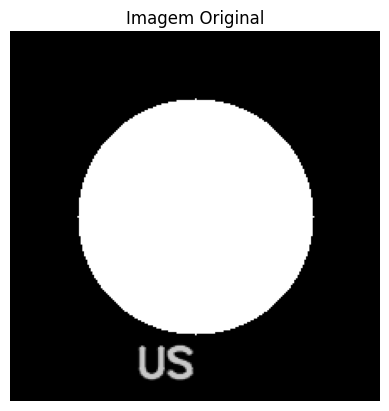

Dimensões: (220, 220) | Média dos pixels: 82.31


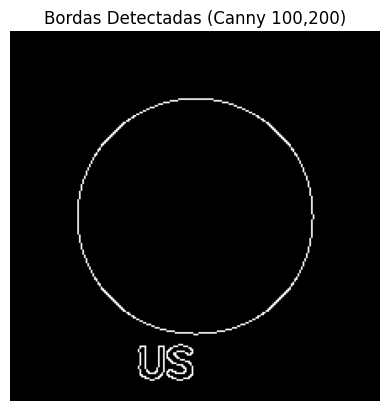

Resultado salvo em: /content/aula-pratica-python/dados/bordas.png


In [22]:
# Carregar imagem (sempre deste caminho padronizado)
img_path = Path('dados') / 'imagem1.png'

if not img_path.exists():
    raise FileNotFoundError(f"Não encontrei {img_path}. Algo impediu o setup de criar a imagem.")

img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
if img is None:
    raise RuntimeError("OpenCV não conseguiu carregar a imagem. Verifique o arquivo.")

# Mostrar imagem original
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')
plt.show()

print(f"Dimensões: {img.shape} | Média dos pixels: {np.mean(img):.2f}")

# Detecção de bordas (alunos podem brincar com os thresholds)
t1, t2 = 100, 200       # experimente (50,150) ou (150,250)
edges = cv2.Canny(img, t1, t2)

plt.imshow(edges, cmap='gray')
plt.title(f'Bordas Detectadas (Canny {t1},{t2})')
plt.axis('off')
plt.show()

# (Opcional) salvar resultado
out_path = Path('dados') / 'bordas.png'
cv2.imwrite(str(out_path), edges)
print("Resultado salvo em:", out_path.resolve())

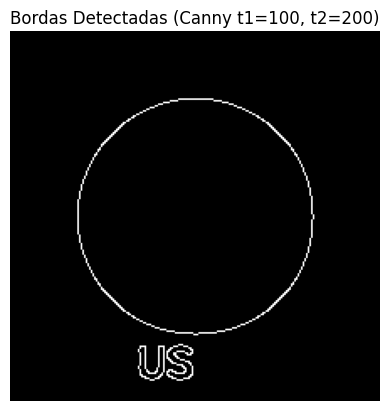

In [23]:
# ✂️ Detecção de bordas (Canny) — ajuste os thresholds e rode novamente
t1, t2 = 100, 200  # experimente (50,150) ou (150,250)
edges = cv2.Canny(img, t1, t2)

plt.imshow(edges, cmap='gray')
plt.title(f'Bordas Detectadas (Canny t1={t1}, t2={t2})')
plt.axis('off')
plt.show()

In [24]:
# 💾 (Opcional) salvar a imagem de bordas
out_path = Path('dados') / 'bordas.png'
cv2.imwrite(str(out_path), edges)
print('Arquivo salvo em:', out_path.resolve())

Arquivo salvo em: /content/aula-pratica-python/dados/bordas.png
